# Import libraries #

In [1]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib . pyplot as plt
import xml. etree . ElementTree as ET

from skimage . transform import resize
from skimage import feature
from sklearn .svm import SVC
from sklearn . preprocessing import LabelEncoder
from sklearn . preprocessing import StandardScaler
from sklearn . model_selection import train_test_split
from sklearn . metrics import accuracy_score

# Read data (images + notations) in folders #

In [2]:
annotations_dir = 'C:\\Users\\admin\\Desktop\\University\\ML platform\\project\\final_dataset\\annotations'
img_dir = 'C:\\Users\\admin\\Desktop\\University\\ML platform\\project\\final_dataset\\images'
img_lst = []
label_lst = []

In [3]:
for xml_file in os.listdir(annotations_dir):
    xml_filepath = os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    print(f"Processing file: {xml_file}")  # Print each XML file being processed

    # Load the image based on the filename in XML
    img_filename = root.find('filename').text
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)

    # Loop through objects in the XML file
    for obj in root.findall('object'):
        classname = obj.find('name').text
        print(f"Found object class: {classname}")  # Print each object class found

        # Skip 'trafficlight' if not needed
        if classname == 'trafficlight': # or classname == 'crosswalk':
            continue

        # Only add objects that match 'stop', 'crosswalk', or 'speedlimit'
        if classname in ['stop', 'speedlimit','turn_right','no_parking','crosswalk']:
            # Extract bounding box coordinates
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            # Crop the object and add it to lists
            object_img = img[ymin:ymax, xmin:xmax]
            img_lst.append(object_img)
            label_lst.append(classname)

            # Print each added object to confirm it's being added
            print(f"Added object: {classname}, Total objects so far: {len(img_lst)}")

# Final check
print('Number of objects:', len(img_lst))
print('Class names:', list(set(label_lst)))

Processing file: road0.xml
Found object class: trafficlight
Processing file: road1.xml
Found object class: trafficlight
Processing file: road10.xml
Found object class: trafficlight
Processing file: road100.xml
Found object class: speedlimit
Added object: speedlimit, Total objects so far: 1
Processing file: road1000.xml
Found object class: crosswalk
Added object: crosswalk, Total objects so far: 2
Processing file: road1001.xml
Found object class: crosswalk
Added object: crosswalk, Total objects so far: 3
Processing file: road1002.xml
Found object class: crosswalk
Added object: crosswalk, Total objects so far: 4
Found object class: crosswalk
Added object: crosswalk, Total objects so far: 5
Found object class: crosswalk
Added object: crosswalk, Total objects so far: 6
Processing file: road1003.xml
Found object class: crosswalk
Added object: crosswalk, Total objects so far: 7
Processing file: road1004.xml
Found object class: crosswalk
Added object: crosswalk, Total objects so far: 8
Proces

In [4]:
from collections import Counter

# Assuming 'label_lst' contains the class labels from your dataset
# Example: label_lst = ['crosswalk', 'no_parking', 'speedlimit', 'crosswalk', ...]

# Count the occurrences of each class
class_counts = Counter(label_lst)

# Print the count for each class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}' has {count} samples.")

Class 'speedlimit' has 773 samples.
Class 'crosswalk' has 637 samples.
Class 'no_parking' has 608 samples.
Class 'stop' has 783 samples.
Class 'turn_right' has 883 samples.


## Preprocess with HOG (Histogram of Oriented Gradients) ##

In [5]:
from skimage import feature
from skimage.transform import resize
import cv2
import numpy as np

def preprocess_img(img):
    # Convert the image to grayscale if it has more than one channel
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert image to float32 type
    img = img.astype(np.float32)
    
    # Resize the image to 32x32 with anti-aliasing
    resized_img = resize(
        img,
        output_shape=(32, 32),
        anti_aliasing=True
    )
    
    # Extract HOG features with the specified parameters
    hog_feature = feature.hog(
        resized_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm="L2",
        feature_vector=True
    )
    
    return hog_feature

In [6]:
img_features_lst = []
for img in img_lst:
    hog_feature = preprocess_img(img) 
    img_features_lst.append(hog_feature)

# Convert the list of HOG features to a numpy array for further processing
img_features = np.array(img_features_lst)

In [7]:
print('Shape of the image before preprocessing:', img_lst[0].shape)
hog_feature = preprocess_img(img_lst[0])
print('Shape of the image after preprocessing:', hog_feature.shape)

Shape of the image before preprocessing: (321, 328, 3)
Shape of the image after preprocessing: (324,)


## Encode Labels ##

In [8]:
from sklearn.preprocessing import LabelEncoder

# Convert the class labels (e.g., "stop", "crosswalk", "speedlimit") into numeric form 
# because machine learning models work better with numerical data.

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)  # Encode the labels

## Split for training and validation ##

In [9]:
from sklearn.model_selection import train_test_split

#split 70% train , 30% validation
random_state = 0
test_size = 0.3
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_features, encoded_labels,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

## Normalize data ##

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Train SVM model ##

In [12]:
from sklearn.svm import SVC

clf = SVC(
    kernel='rbf',
    random_state=random_state,
    probability=True,
    C=0.5
)
clf.fit(X_train, y_train)

SVC(C=0.5, probability=True, random_state=0)

## Evalute model ##

In [13]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_val)
score = accuracy_score(y_val, y_pred)
print('Evaluation results on val set')
print('Accuracy:', score)

Evaluation results on val set
Accuracy: 0.9945750452079566


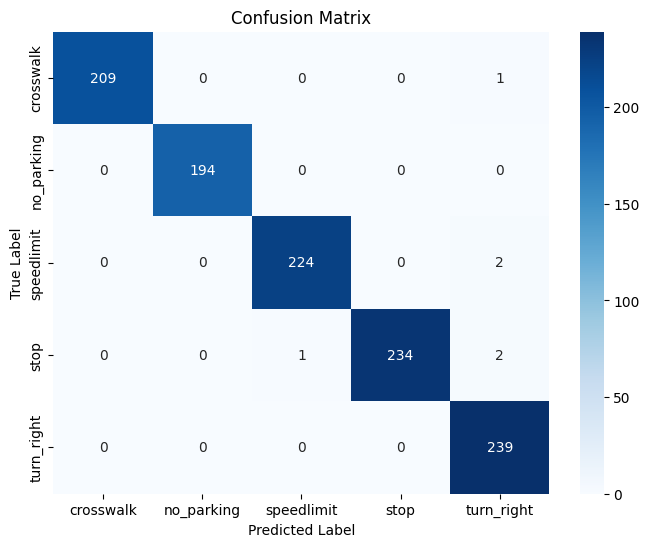

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap="Blues", 
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

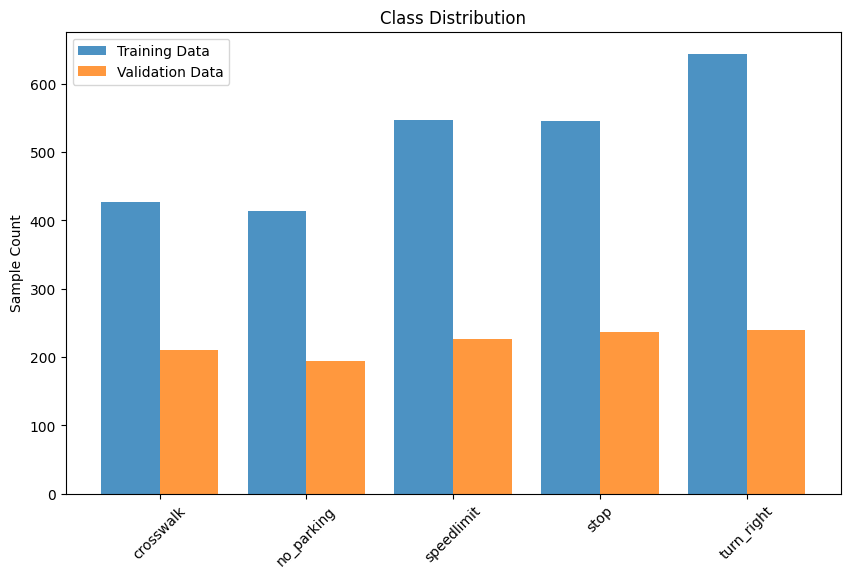

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Count samples per class
train_class_counts = np.bincount(y_train)
val_class_counts = np.bincount(y_val)

# Plot bar chart
labels = label_encoder.classes_
x = np.arange(len(labels))  # Label indices

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, train_class_counts, width=0.4, label="Training Data", alpha=0.8)
plt.bar(x + 0.2, val_class_counts, width=0.4, label="Validation Data", alpha=0.8)

plt.xticks(x, labels, rotation=45)
plt.ylabel("Sample Count")
plt.title("Class Distribution")
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate a classification report with precision, recall, and F1-score
class_report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

   crosswalk       1.00      1.00      1.00       210
  no_parking       1.00      1.00      1.00       194
  speedlimit       1.00      0.99      0.99       226
        stop       1.00      0.99      0.99       237
  turn_right       0.98      1.00      0.99       239

    accuracy                           0.99      1106
   macro avg       1.00      0.99      0.99      1106
weighted avg       0.99      0.99      0.99      1106



# Sliding window #

In [15]:
def sliding_window(img, window_sizes, stride):
    img_height, img_width = img.shape[:2]
    windows = []
    
    for window_size in window_sizes:
        window_width, window_height = window_size
        
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height
                windows.append([xmin, ymin, xmax, ymax])
    
    return windows

In [16]:
def pyramid(img, scale=0.8, min_size=(30, 30)):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]
    
    while True:
        acc_scale *= scale
        w = int(img.shape[1] * acc_scale)
        h = int(img.shape[0] * acc_scale)
        
        if h < min_size[1] or w < min_size[0]:
            break
            
        img = cv2.resize(img, (w, h))
        pyramid_imgs.append((img, acc_scale))
    
    return pyramid_imgs

In [17]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box
        
        # Draw rectangle for bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        
        # Get label and confidence score text
        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score:.2f}"
        
        # Add label above the bounding box
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)
        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    
    # Show the final image with bounding boxes
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [19]:
# Parameters for detection
conf_threshold = 0.85
window_sizes = [(32, 32), (64, 64), (128, 128)]
stride = 12
img_dir = 'C:\\Users\\admin\\Desktop\\University\\ML platform\\project\\final_dataset\\images'
img_filename_lst = os.listdir(img_dir)[:20]

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramid(img)  # Generate the image pyramid
    bboxes = []  # List to store bounding boxes and details

    # Apply sliding window on each level of the pyramid
    for pyramid_img, scale_factor in pyramid_imgs:
        # Generate sliding windows without passing scale_factor
        window_list = sliding_window(pyramid_img, window_sizes, stride)

        # Classify each window
        for window in window_list:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]

            # Preprocess and classify the window
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])
            decision = clf.predict_proba(normalized_img)[0]

            # Check if confidence score meets threshold
            if np.all(decision < conf_threshold):
                continue
            else:
                # Get the highest confidence class and its score
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                
                # Scale the bounding box back to the original image size
                orig_xmin = int(xmin / scale_factor)
                orig_ymin = int(ymin / scale_factor)
                orig_xmax = int(xmax / scale_factor)
                orig_ymax = int(ymax / scale_factor)
                
                # Append bounding box info to bboxes list
                bboxes.append([orig_xmin, orig_ymin, orig_xmax, orig_ymax, predict_id, conf_score])

    # Visualize bounding boxes if desired
   # visualize_bbox(img, bboxes, label_encoder)

## Non-Maximum Suppression ##

In [20]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3])

    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1)

    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection)

    return iou

In [21]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []

    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])
    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    keep = []

    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)

        # Calculate IoU for remaining boxes
        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array([xmin[sorted_indices[1:]],
                      ymin[sorted_indices[1:]],
                      xmax[sorted_indices[1:]],
                      ymax[sorted_indices[1:]]]).T,
            areas[i],
            areas[sorted_indices[1:]]
        )

        # Filter out indices based on IoU threshold
        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]

    return [bboxes[i] for i in keep]


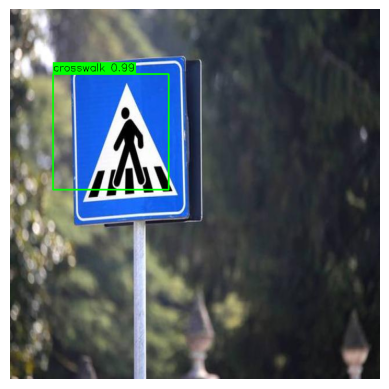

In [22]:
conf_threshold = 0.95  # Set the confidence threshold for detections
iou_threshold = 0.1   # Set the IoU threshold for NMS

# Assume 'bboxes' is a list of bounding boxes in the format [xmin, ymin, xmax, ymax, class_id, confidence_score]
# Filter out low-confidence boxes
bboxes = [bbox for bbox in bboxes if bbox[5] >= conf_threshold]

# Apply NMS
filtered_bboxes = nms(bboxes, iou_threshold=iou_threshold)

# Visualize the results
visualize_bbox(img, filtered_bboxes, label_encoder)

# Testing only

In [44]:
img_dir = 'C:\\Users\\admin\\Desktop\\University\\ML platform\\project\\final_dataset\\images'
start_index = 660
end_index = 664

Processing image: road664.png


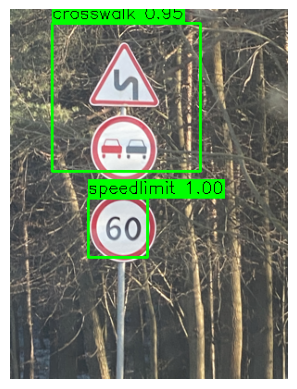

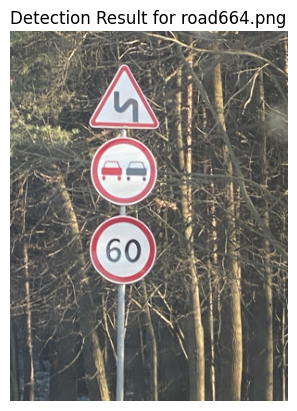

Processing image: road665.png


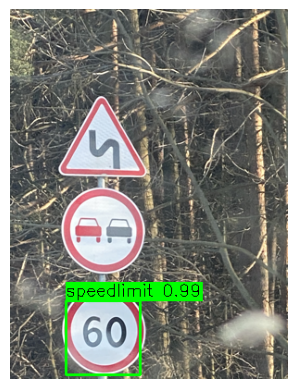

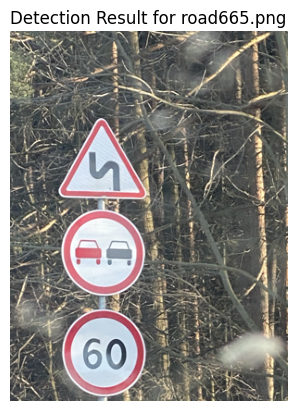

Processing image: road666.png


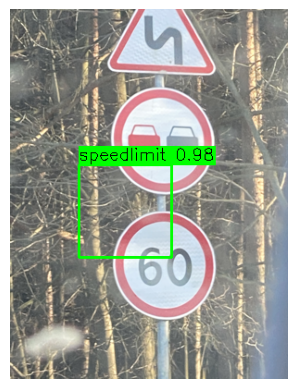

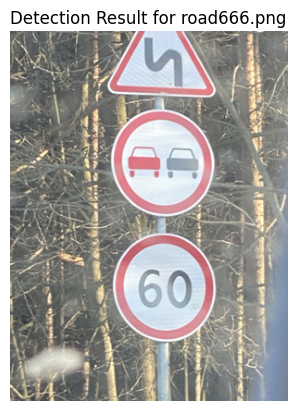

Processing image: road667.png


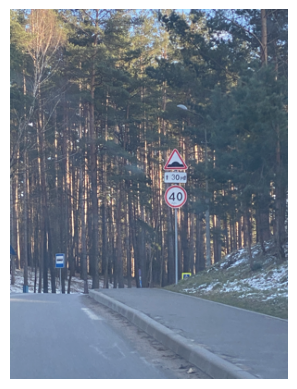

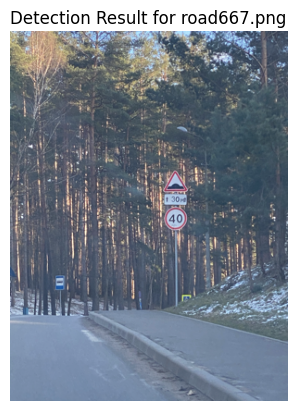

In [45]:
import re

def sorted_numerically(file_list):
    return sorted(file_list, key=lambda x: int(re.search(r'\d+', x).group()))

# Configuration parameters
conf_threshold = 0.95  # Confidence threshold for detections
iou_threshold = 0.1    # IoU threshold for NMS
window_sizes = [(32, 32), (64, 64), (128, 128)]  # Define window sizes for sliding window
stride = 12  # Replace with your actual images directory

# Get a sorted list of image filenames in the directory by numeric order
img_filename_lst = sorted_numerically(os.listdir(img_dir))[start_index:end_index]

# Loop through each selected image
for img_filename in img_filename_lst:
    print(f"Processing image: {img_filename}")
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)

    # If the image couldn't be read, skip it
    if img is None:
        print(f"Warning: Could not read image {img_filename}. Skipping.")
        continue

    start_time = time.time()
    pyramid_imgs = pyramid(img)  # Generate the image pyramid

    bboxes = []  # List to store bounding boxes and details

    # Apply sliding window on each level of the pyramid
    for pyramid_img, scale_factor in pyramid_imgs:
        window_list = sliding_window(pyramid_img, window_sizes, stride)

        for window in window_list:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]

            # Preprocess and classify the window
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])
            decision = clf.predict_proba(normalized_img)[0]

            # Check if confidence score meets threshold
            if np.all(decision < conf_threshold):
                continue
            else:
                # Get the highest confidence class and its score
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]

                # Scale the bounding box back to the original image size
                orig_xmin = int(xmin / scale_factor)
                orig_ymin = int(ymin / scale_factor)
                orig_xmax = int(xmax / scale_factor)
                orig_ymax = int(ymax / scale_factor)

                # Append bounding box info to bboxes list
                bboxes.append([orig_xmin, orig_ymin, orig_xmax, orig_ymax, predict_id, conf_score])

    # Filter out low-confidence boxes
    bboxes = [bbox for bbox in bboxes if bbox[5] >= conf_threshold]

    # Apply NMS
    filtered_bboxes = nms(bboxes, iou_threshold=iou_threshold)

    # Visualize bounding boxes on the original image
    visualize_bbox(img, filtered_bboxes, label_encoder)

    # Display the result for each image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Detection Result for {img_filename}")
    plt.show()